# Create Custom Node Parser - Small chunk referring to Bigger(Parent) Chunk

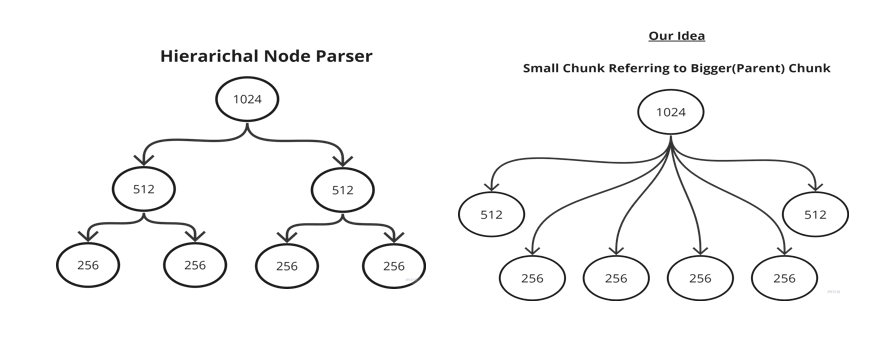

> We need GPU with around 12gb RAM to run this Notebook. You can use free GPU P100 available on kaggle or use Colab free GPU.

# Using Llama v.10

They have done lot of changes in their repo. You can refer to below blog post -

https://blog.llamaindex.ai/llamaindex-v0-10-838e735948f8

# Install Packages

In [1]:
!pip install llama-index-llms-huggingface llama-index-embeddings-huggingface llama-index transformers accelerate bitsandbytes --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


# Downloading data
It's a pdf having current affairs info.

In [2]:
!mkdir -p 'data/'
!wget --user-agent "Mozilla" "https://chahalacademy.com/assets/pdf/Compilation%20of%20Yojana%20And%20Kurukshetra.pdf" -O "data/Yojana.pdf"

--2024-02-20 16:17:14--  https://chahalacademy.com/assets/pdf/Compilation%20of%20Yojana%20And%20Kurukshetra.pdf
Resolving chahalacademy.com (chahalacademy.com)... 103.227.176.27
Connecting to chahalacademy.com (chahalacademy.com)|103.227.176.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32739743 (31M) [application/pdf]
Saving to: 'data/Yojana.pdf'

data/Yojana.pdf     100%[===================>]  31.22M  39.8MB/s    in 0.8s    

2024-02-20 16:17:15 (39.8 MB/s) - 'data/Yojana.pdf' saved [32739743/32739743]



# Import required packages

If you get below error while importing the packages, **please run the below cell again it will work.** Some kind of circular import bug in latest LlamaIndex version

> ImportError: cannot import name 'BasePromptTemplate' from partially initialized module 'llama_index.core.prompts' (most likely due to a circular import) (/opt/conda/lib/python3.10/site-packages/llama_index/core/prompts/__init__.py)

In [4]:
from pathlib import Path
from llama_index.core.prompts import PromptTemplate
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.retrievers import RecursiveRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import VectorStoreIndex
from llama_index.core import Document
import json

import torch
from transformers import BitsAndBytesConfig
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core import Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.schema import IndexNode
from llama_index.core.node_parser import HierarchicalNodeParser,get_leaf_nodes
from llama_index.core.retrievers.auto_merging_retriever import AutoMergingRetriever
from llama_index.core.storage.docstore import SimpleDocumentStore
from llama_index.core.storage import StorageContext
from llama_index.readers.file import PDFReader,PyMuPDFReader

# Loading the data

In [5]:
loader = PyMuPDFReader()
docs0 = loader.load_data(file_path=Path("./data/Yojana.pdf"))
# filtering idx<=2 to exclude first 2 pages having contents info with page number.
doc_text = "\n\n".join([d.get_content() for idx, d in enumerate(docs0) if idx>2])
docs = [Document(text=doc_text)]

# Downloading open source LLM(Zephyr) using HuggingFaceLLM and doing quantization

In [6]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)


def messages_to_prompt(messages):
    prompt = ""
    for message in messages:
        if message.role == 'system':
            prompt += f"<|system|>\n{message.content}</s>\n"
        elif message.role == 'user':
            prompt += f"<|user|>\n{message.content}</s>\n"
        elif message.role == 'assistant':
            prompt += f"<|assistant|>\n{message.content}</s>\n"

    # ensure we start with a system prompt, insert blank if needed
    if not prompt.startswith("<|system|>\n"):
        prompt = "<|system|>\n</s>\n" + prompt

    # add final assistant prompt
    prompt = prompt + "<|assistant|>\n"

    return prompt


Settings.llm = HuggingFaceLLM(
    model_name="HuggingFaceH4/zephyr-7b-alpha",
    tokenizer_name="HuggingFaceH4/zephyr-7b-alpha",
    query_wrapper_prompt=PromptTemplate("<|system|>\n</s>\n<|user|>\n{query_str}</s>\n<|assistant|>\n"),
    context_window=3900,
    max_new_tokens=256,
    model_kwargs={"quantization_config": quantization_config},
    # tokenizer_kwargs={},
    generate_kwargs={"do_sample": False},
    messages_to_prompt=messages_to_prompt,
    device_map="auto",
)

config.json:   0%|          | 0.00/628 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

# Downloading bge-base embedding model

In [7]:
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

# HierarchicalNodeParser

In [8]:
hier_node_parser = HierarchicalNodeParser.from_defaults([1024,512,256], 
                                                        chunk_overlap=0)
hier_nodes = hier_node_parser.get_nodes_from_documents(docs)
leaf_nodes = get_leaf_nodes(hier_nodes)


docstore = SimpleDocumentStore()
# insert nodes into docstore
docstore.add_documents(hier_nodes)
# define storage context (will include vector store by default too)
storage_context = StorageContext.from_defaults(docstore=docstore)

In [9]:
base_index = VectorStoreIndex(
    leaf_nodes,
    storage_context=storage_context,
)

# AutoMergingRetriever

It looks at a set of leaf nodes and recursively “merges” subsets of leaf nodes that reference a parent node beyond a given threshold. This allows us to consolidate potentially disparate, smaller contexts into a larger context that might help synthesis.

> # Set simple_ratio_thresh = 0.0 so that it gives parent node in place of child node.

In [10]:
base_retriever = base_index.as_retriever(similarity_top_k=3)
retriever = AutoMergingRetriever(base_retriever,simple_ratio_thresh = 0.0, storage_context=storage_context, verbose=True)

In [11]:
query_engine = RetrieverQueryEngine.from_args(retriever)

# Let's test the RAG system on questions from the pdf.

In [12]:
questions = [
    "Which Country is the largest producer of millets?",
    "What is Samagra Shiksha Scheme?",
    "Which new initiative is proposed in budget to eliminate anaemia by 2047.",
    "What is the median age of India, China and Germany?",
    "How much budget is allocated to Natural farming?",
    "According to the given context information, what is the estimated fiscal deficit as a percentage of GDP for the year 2023-24?",
    "What is Mission LiFE and what are its objectives?",
    "What is the potential of wind energy in India, as identified by the National Institute of Wind Energy?"
]

In [13]:
for q in questions:
    response = query_engine.query(q)
    print("Question -", q,"\n")
    print("Response - ", response,"\n\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


> Merging 2 nodes into parent node.
> Parent node id: c2340517-e662-4ba9-b6ba-85a074c6581b.
> Parent node text: MILLETS  
1
MILLETS
Yojana (January 2023)
INTERNATIONAL YEAR OF MILLETS 2023
India’s effort has r...

> Merging 1 nodes into parent node.
> Parent node id: 6391c693-609f-4710-a887-fbc962ac9649.
> Parent node text: • Green manures: green manures like Leguminous 
plants, which make up the majority of green manur...

> Merging 1 nodes into parent node.
> Parent node id: 74f02d58-2dee-4d30-9963-962c521d4f23.
> Parent node text: MILLETS  
1
MILLETS
Yojana (January 2023)
INTERNATIONAL YEAR OF MILLETS 2023
India’s effort has r...

> Merging 1 nodes into parent node.
> Parent node id: 2652b518-ccf7-4a05-b052-35cbbb8ae9b0.
> Parent node text: The cereal 
primarily contains unsaturated fat, which has a low-fat 
content. Given its lower gly...



2024-02-20 16:22:44.578952: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 16:22:44.579087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 16:22:44.701073: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - Which Country is the largest producer of millets? 

Response -  India is the largest producer of millets, accounting for 20% of global production. 


> Merging 1 nodes into parent node.
> Parent node id: 1e1cf118-12d0-433a-a1ad-7ca8e5f3556b.
> Parent node text: ¾ 
To spread awareness on fitness and various 
physical activities that promote fitness through 
...

> Merging 2 nodes into parent node.
> Parent node id: 4e8ea7c1-8420-4b1c-a4c7-ec1bb9dfd767.
> Parent node text: 16 
UNION BUDGET 
Mahatma 
Gandhi 
National 
Rural 
Employment 
Guarantee Scheme
• It seeks to st...

> Merging 1 nodes into parent node.
> Parent node id: 77b52c73-3eed-4840-a63d-b7998fb244ab.
> Parent node text: 4 
YOUTH AND SPORTS
YOUTH AND SPORTS
(YOJANA FEBRUARY 2023)
India has one of the youngest populat...

> Merging 1 nodes into parent node.
> Parent node id: f3ec2c36-5583-42a1-b867-a7018abc3c68.
> Parent node text: 16 
UNION BUDGET 
Mahatma 
Gandhi 
National 
Rural 
Employment 
Guarantee Scheme
• It

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - What is Samagra Shiksha Scheme? 

Response -  The Samagra Shiksha Scheme is a Centrally Sponsored Scheme that has been aligned with the policy. Under this scheme, sports grants are provided annually to all government schools. 


> Merging 1 nodes into parent node.
> Parent node id: d8d4030b-2cf1-46ed-9eff-76077c4ddc80.
> Parent node text: • A new initiative is proposed in budget to eliminate 
anaemia by 2047.
• A special scheme namely...

> Merging 2 nodes into parent node.
> Parent node id: 70177385-736f-440c-bf18-f810af4b2d73.
> Parent node text: • The National Green Hydrogen Mission, with an 
outlay of Rs 19,700 crore is planned with a targe...

> Merging 2 nodes into parent node.
> Parent node id: b1eea0cf-7f32-4bbe-8a68-2ee650bf0f98.
> Parent node text: • A new initiative is proposed in budget to eliminate 
anaemia by 2047.
• A special scheme namely...



Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - Which new initiative is proposed in budget to eliminate anaemia by 2047. 

Response -  A special scheme namely Sickle Cell Anaemia Elimination Mission would be launched to eliminate anaemia by 2047. 


> Merging 1 nodes into parent node.
> Parent node id: 7546b9d8-b477-4b65-80e8-20e5b8a5b403.
> Parent node text: Start-Up India  
17
Start-Up India
Yojana (April 2023)
Today the world is rapidly ageing, but Ind...

> Merging 1 nodes into parent node.
> Parent node id: 525acfd8-275f-4fc5-8f51-201f695be0ab.
> Parent node text: The Union Budget 2023-24 has emphasised 
‘Amrit Peedhi’ as a priority under the ‘Saptarishi’ guid...

> Merging 1 nodes into parent node.
> Parent node id: 8ee3fa3a-6652-4fa3-8d38-a9e7a976717f.
> Parent node text: 4 
YOUTH AND SPORTS
YOUTH AND SPORTS
(YOJANA FEBRUARY 2023)
India has one of the youngest populat...

> Merging 1 nodes into parent node.
> Parent node id: 21aea0a4-0ae8-416d-aea5-cc6088498008.
> Parent node text: Start-Up India  
17
Start-Up Indi

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - What is the median age of India, China and Germany? 

Response -  The median age in India is 28.4, while in China it is 38 and in Germany it is 47. 


> Merging 1 nodes into parent node.
> Parent node id: 638ec9e2-02e1-45a0-9944-8e65661a594c.
> Parent node text: 14 
UNION BUDGET 
Conclusion: Budget 2023-24 is the first to be presented 
in India’s Amrit kaal....

> Merging 1 nodes into parent node.
> Parent node id: 124aee70-651d-46ba-90c6-114e510e29be.
> Parent node text: SUSTAINABLE AGRICULTURE DEVELOPMENT  
43
¾ 
Rainfed farming: Crop cultivation without 
irrigation...

> Merging 1 nodes into parent node.
> Parent node id: 01d467ea-19b7-4b40-a563-6e96cc03e632.
> Parent node text: 10 
UNION BUDGET 
• Government has proposed in budget to develop 
Hyderabad-based ICAR’s Indian M...

> Merging 1 nodes into parent node.
> Parent node id: b8483bb0-ea62-40b5-a4f6-0ab52dd32bbe.
> Parent node text: 14 
UNION BUDGET 
Conclusion: Budget 2023-24 is the first to be presented 
in India’

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - How much budget is allocated to Natural farming? 

Response -  The budget provision for Natural farming is Rs. 459 crores in the given context information. 


> Merging 1 nodes into parent node.
> Parent node id: bedafd13-979a-4846-b4c4-b338ff1c1435.
> Parent node text: • The newly-announced scheme in the Union Budget 
2023-24, PM VIshwakarma KAushal Samman (PM 
VIK...

> Merging 1 nodes into parent node.
> Parent node id: bf7d9c89-8458-48cb-97b5-3ed56dfcd5ee.
> Parent node text: Revenue Deficit and Sustainable Path
• The government has proposed a tight revenue deficit of 
2....

> Merging 1 nodes into parent node.
> Parent node id: 07c7411a-0901-4f21-b05a-410a201ef8bf.
> Parent node text: • Considering the post-Covid impact, global headwinds, 
Russia Ukraine war, and other geopolitica...

> Merging 2 nodes into parent node.
> Parent node id: a921ebb3-3f03-4af1-92db-841a3509a73c.
> Parent node text: Youth Power - One of the 7 Top Priorities
• Yuva Shakti is the prime driver 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - According to the given context information, what is the estimated fiscal deficit as a percentage of GDP for the year 2023-24? 

Response -  The estimated fiscal deficit as a percentage of GDP for the year 2023-24 is 5.9 per cent, as mentioned in the given context information. 


> Merging 2 nodes into parent node.
> Parent node id: a7f47de4-51f1-42e9-81af-8711e005dd8c.
> Parent node text: INDIA GIFTING HOLISTIC WELL BEING TO THE WORLD   
23
INDIA GIFTING HOLISTIC WELL 
BEING TO THE WO...

> Merging 1 nodes into parent node.
> Parent node id: da46cbc1-a8ee-4d0b-8ac4-b8c297bfe380.
> Parent node text: Shyama Prasad Mukherji Rurban Mission
• It aims at developing cluster of villages that preserve 
...

> Merging 1 nodes into parent node.
> Parent node id: edb3edd3-82f6-4404-9748-02be7d5f8874.
> Parent node text: INDIA GIFTING HOLISTIC WELL BEING TO THE WORLD   
23
INDIA GIFTING HOLISTIC WELL 
BEING TO THE WO...

> Merging 1 nodes into parent node.
> Parent node id: f3ec2c36-5583

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - What is Mission LiFE and what are its objectives? 

Response -  Mission LiFE is an India-led global mass movement aimed at combating climate change by promoting a lifestyle that is synchronous with nature and does not harm it. Its objectives are to mobilize at least one billion Indians and other global citizens to take individual and collective action for protecting and preserving the environment during 2022-2027. Within India, at least 80% of all villages and urban local bodies are aimed to become environment-friendly by 2028. The ideas and ideals of LiFE will be implemented as a mission-mode, scientific, and measurable programme. The main objective is to nudge individuals and communities to practice a lifestyle that is synchronous with nature and does not harm it, and those who practice such a lifestyle are recognized as 'Pro Planet People.' 


> Merging 2 nodes into parent node.
> Parent node id: 389a05ba-05ea-4c2c-b469-4a1eaaba86d3.
> Parent node text: RENEWABLE RESOURCE

# Custom ParentToChildrenNodeParser
 > ### Smaller Child Chunks Referring to Bigger Parent Chunk

In this usage example, we show how to build a graph of smaller chunks pointing to bigger parent chunks.

During query-time, we retrieve smaller chunks, but we follow references to bigger chunks. This allows us to have more context for synthesis.

In [14]:
from typing import Any, Dict, List, Optional, Sequence, Tuple

from llama_index.core.bridge.pydantic import Field
from llama_index.core.callbacks.base import CallbackManager
from llama_index.core.callbacks.schema import CBEventType, EventPayload
from llama_index.core.node_parser.interface import NodeParser
from llama_index.core.node_parser.text.sentence import SentenceSplitter
from llama_index.core.schema import BaseNode, Document, NodeRelationship, IndexNode
from llama_index.core.utils import get_tqdm_iterable

class ParentToChildrenNodeParser(NodeParser):
    """Parent to Child node parser.

    Splits a document into a recursive hierarchy Nodes using a NodeParser.

    NOTE: this will return a hierarchy of nodes in a flat list, where there will be
    overlap between parent nodes (e.g. with a bigger chunk size), and child nodes
    per parent (e.g. with a smaller chunk size).

    For chunk_sizes as [2048, 512, 128]
        - First index value(2048) will be treated as parent node
        - Rest other index values(512,128) will be child nodes pointing directly to parent node(2048)
        using IndexNode.
    """

    chunk_sizes: Optional[List[int]] = Field(
        default=None,
        description=(
            "The chunk sizes to use when splitting documents, in order of level."
        ),
    )
    node_parser_ids: List[str] = Field(
        default_factory=list,
        description=(
            "List of ids for the node parsers to use when splitting documents, "
            + "in order of level (first id used for first level, etc.)."
        ),
    )
    node_parser_map: Dict[str, NodeParser] = Field(
        description="Map of node parser id to node parser.",
    )

    @classmethod
    def from_defaults(
        cls,
        chunk_sizes: Optional[List[int]] = None,
        chunk_overlap: int = 20,
        node_parser_ids: Optional[List[str]] = None,
        node_parser_map: Optional[Dict[str, NodeParser]] = None,
        include_metadata: bool = True,
        include_prev_next_rel: bool = True,
        callback_manager: Optional[CallbackManager] = None,
    ) -> "ParentToChildrenNodeParser":
        callback_manager = callback_manager or CallbackManager([])

        if node_parser_ids is None:
            if chunk_sizes is None:
                chunk_sizes = [2048, 512, 128]

            node_parser_ids = [f"chunk_size_{chunk_size}" for chunk_size in chunk_sizes]
            node_parser_map = {}
            for chunk_size, node_parser_id in zip(chunk_sizes, node_parser_ids):
                node_parser_map[node_parser_id] = SentenceSplitter(
                    chunk_size=chunk_size,
                    callback_manager=callback_manager,
                    chunk_overlap=chunk_overlap,
                    include_metadata=include_metadata,
                    include_prev_next_rel=include_prev_next_rel,
                )
        else:
            if chunk_sizes is not None:
                raise ValueError("Cannot specify both node_parser_ids and chunk_sizes.")
            if node_parser_map is None:
                raise ValueError(
                    "Must specify node_parser_map if using node_parser_ids."
                )

        return cls(
            chunk_sizes=chunk_sizes,
            node_parser_ids=node_parser_ids,
            node_parser_map=node_parser_map,
            include_metadata=include_metadata,
            include_prev_next_rel=include_prev_next_rel,
            callback_manager=callback_manager,
        )

    @classmethod
    def class_name(cls) -> str:
        return "ParentToChildrenNodeParser"

    def _get_nodes_from_doc(
        self,
        docs: List[Document],
        show_progress: bool = False,
    ) -> Tuple[List[BaseNode],Dict[str, BaseNode]]:
        """get nodes from docs."""

        # first split current nodes into sub-nodes
        docs_with_progress = get_tqdm_iterable(
            docs, show_progress, "Parsing documents into nodes"
        )
        base_nodes = []
        for node in docs_with_progress:
            cur_sub_nodes = self.node_parser_map[
                self.node_parser_ids[0]
            ].get_nodes_from_documents([node])
            base_nodes.extend(cur_sub_nodes)
        
        for idx, node in enumerate(base_nodes):
            node.id_ = f"node-{idx}"
        
        nodes_with_progress = get_tqdm_iterable(
            base_nodes, show_progress, "Parsing nodes into sub nodes"
        )
        all_nodes = []
        for node in nodes_with_progress:
            for level in range(len(self.node_parser_ids)):
                if level>0:
                    cur_sub_nodes = self.node_parser_map[
                        self.node_parser_ids[level]
                    ].get_nodes_from_documents([node])
                    sub_inodes = [
                        IndexNode.from_text_node(sn, node.node_id) for sn in cur_sub_nodes
                    ]
                    all_nodes.extend(sub_inodes)
            
        return all_nodes, {n.node_id: n for n in base_nodes}

    def get_nodes_from_documents(
        self,
        documents: Sequence[Document],
        show_progress: bool = False,
        **kwargs: Any,
    ) -> List[BaseNode]:
        """Parse document into nodes.

        Args:
            documents (Sequence[Document]): documents to parse
            include_metadata (bool): whether to include metadata in nodes

        """
        with self.callback_manager.event(
            CBEventType.NODE_PARSING, payload={EventPayload.DOCUMENTS: documents}
        ) as event:
            all_nodes: List[BaseNode] = []
            all_base_nodes_dict: Dict[str, BaseNode] = dict()
            documents_with_progress = get_tqdm_iterable(
                documents, show_progress, "Parsing documents into nodes"
            )
            for doc in documents_with_progress:
                nodes_from_doc,base_nodes_dict = self._get_nodes_from_doc([doc])
                all_nodes.extend(nodes_from_doc)
                all_base_nodes_dict.update(base_nodes_dict)
            event.on_end(payload={EventPayload.NODES: all_nodes})

        return all_nodes, all_base_nodes_dict

    # Unused abstract method
    def _parse_nodes(
        self, nodes: Sequence[BaseNode], show_progress: bool = False, **kwargs: Any
    ) -> List[BaseNode]:
        return list(nodes)

In [15]:
p2c_node_parser = ParentToChildrenNodeParser.from_defaults([1024,512,256], chunk_overlap=0)
all_nodes,all_base_nodes_dict = p2c_node_parser.get_nodes_from_documents(docs)
len(all_nodes)

219

In [16]:
vector_index_chunk = VectorStoreIndex(all_nodes)
vector_retriever_chunk = vector_index_chunk.as_retriever(similarity_top_k=3)

# RecursiveRetriever

This guide shows how you can use recursive retrieval to traverse node relationships and fetch nodes based on “references”.

Node references are a powerful concept. When you first perform retrieval, you may want to retrieve the reference as opposed to the raw text. You can have multiple references point to the same node.

In this guide we explore some different usages of node references:

> Chunk references: Different chunk sizes referring to a bigger chunk


In [17]:
retriever_chunk = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever_chunk},
    node_dict=all_base_nodes_dict,
    verbose=True,
)

In [18]:
nodes = retriever_chunk.retrieve(questions[0])
for node in nodes:
    display_source_node(node, source_length=10000)

Retrieving with query id None: Which Country is the largest producer of millets?
Retrieved node with id, entering: node-0
Retrieving with query id node-0: Which Country is the largest producer of millets?


**Node ID:** node-0<br>**Similarity:** 0.7960905617915388<br>**Text:** MILLETS  
1
MILLETS
Yojana (January 2023)
INTERNATIONAL YEAR OF MILLETS 2023
India’s effort has resulted into United Nation’s declaration 
of year 2023 as International Year of Millets (IYM). India 
is on the way to become the global hub of millet production 
with more than 80% of Asia’s share of production of 
millets. India is the world’s largest producer of millets, 
accounting 20% of global production and having average 
yield of 1237 kg/hectare more than global average of 1229 
kg/hectare. Government of India has declared to celebrate 
the IYM as a Jan Andolan so that Indian millets, recipes 
and value-added products are accepted globally. The top 
five state producing millets are Rajasthan, Karnataka, 
Maharashtra, Uttar Pradesh and Haryana.
Millet production in India
According to World Food Programme, there are an 
estimated 1.2 billion people who consume millet as part 
of their diet.
Millet production has been stable over the past few 
years, with an estimated production of 28 million 
metric tons in 2020.
India is the largest producer of millet, followed by 
Niger and China.
The Food and Agriculture Organisation (FAO) has held 
that it would raise the awareness about production of 
millets in its member nations. Once in life-time event of 
COVID-19, the ill-effects of climate change have led to 
the challenge of food and nutrition security across world. 
Millets, which are drought proof crop and nutrient rich 
crop can solve this problem.
IYM 2023 aims to contribute to the UN 2030 Agenda 
for Sustainable Development, particularly SDG 2 (Zero 
Hunger), SDG 3 (Good health and well-being), SDG 8 
(Decent work and economic growth), SDG 12 (Responsible 
consumption and production), SDG 13 (Climate action) 
and SDG 15 (Life on land).
Benefits of Millets:
• Support climate-resilient agriculture - Millets are 
hardy species, which can tolerate water stresses, at the 
same time they can help in carbon sequestering. 
• Contributes to food security and nutrition - Millets 
can be grown in water scarce dry regions; they are also 
nutrient rich compared to any other grains. 
• Millets can be important part of a healthy diet - 
Millets are good sources of minerals, dietary fibre, 
antioxidants and protein. With a low glycaemic index, 
they are a good option for people with high-blood 
sugar. Millets are also gluten-free and an excellent and 
cost-effective source of iron for iron-deficient diets. As 
whole grains, each variety of millets provide different 
amounts and types of fibre. Dietary fibre has a role in 
regulating bowel function, blood sugar and lipids, and 
satiation. 
• Greater 
consumption 
of 
millets 
can 
offer 
opportunities to smallholder farmers to improve 
their livelihoods.
• Greater trade in millets can improve the diversity of 
the global food system - This not only improve the 
decent work and economic growth (SDG 8) but also 
the sustainable consumption and production (SDG 12) 
in the world.
Although millets were grown and used in Indian 
Subcontinent since ancient times, its use decreased 
significantly since green revolution came to India. Many 
ancient Indian texts cites cultivation and use of millets, 
many songs and couplets are written on millets. 
Over the years due to a multitude of factors. Socio-
economic dynamics resulting from the hardy nature of the 
crop, relegated them to be the grain of the poor. In many 
1


2 
MILLETS
places the use of millets is systematically discouraged from 
cultivation; for example, Kodo Kotki Hatao Soyabean Lagao 
(Remove Kodo and Little millets and grow soyabean) was 
a famous slogan from 2000s undivided Madhya Pradesh.
Nutrition from millets
Apart from being inexpensive and easier to grow, they 
are a rich source of many vitamins, minerals, and fibre. 
o  Niacin, a type of Vitamin B found in millets is useful in 
energy production, and nerve health and keeps the digestive 
tract healthy.  
o  The magnesium. Zinc, and fibre found in millets make it 
an excellent food for blood sugar regulation, especially for 
PCOD and Diabetes. Folic acid helps with iron assimilation 
and improves skin, health, and fertility.
o  The absence of gluten makes it simple to digest.<br>

# RetrieverQueryEngine

In [19]:
query_engine_chunk = RetrieverQueryEngine.from_args(retriever_chunk)

In [20]:
for q in questions:
    response = query_engine_chunk.query(q)
    print("Question -", q,"\n")
    print("Response - ", response,"\n\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: Which Country is the largest producer of millets?
Retrieved node with id, entering: node-0
Retrieving with query id node-0: Which Country is the largest producer of millets?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - Which Country is the largest producer of millets? 

Response -  India is the largest producer of millets, accounting for 20% of global production. 


Retrieving with query id None: What is Samagra Shiksha Scheme?
Retrieved node with id, entering: node-3
Retrieving with query id node-3: What is Samagra Shiksha Scheme?
Retrieved node with id, entering: node-13
Retrieving with query id node-13: What is Samagra Shiksha Scheme?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - What is Samagra Shiksha Scheme? 

Response -  The Samagra Shiksha Scheme is a Centrally Sponsored Scheme that has been aligned with the policy. Under this scheme, sports grants are provided annually to all government schools. 


Retrieving with query id None: Which new initiative is proposed in budget to eliminate anaemia by 2047.
Retrieved node with id, entering: node-6
Retrieving with query id node-6: Which new initiative is proposed in budget to eliminate anaemia by 2047.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - Which new initiative is proposed in budget to eliminate anaemia by 2047. 

Response -  A special scheme namely Sickle Cell Anaemia Elimination Mission would be launched to eliminate anaemia by 2047. 


Retrieving with query id None: What is the median age of India, China and Germany?
Retrieved node with id, entering: node-14
Retrieving with query id node-14: What is the median age of India, China and Germany?
Retrieved node with id, entering: node-8
Retrieving with query id node-8: What is the median age of India, China and Germany?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - What is the median age of India, China and Germany? 

Response -  The median age in India is 28.4, while it is 38 in China and 47 in Germany. 


Retrieving with query id None: How much budget is allocated to Natural farming?
Retrieved node with id, entering: node-11
Retrieving with query id node-11: How much budget is allocated to Natural farming?
Retrieved node with id, entering: node-6
Retrieving with query id node-6: How much budget is allocated to Natural farming?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - How much budget is allocated to Natural farming? 

Response -  According to the given context information, the budget provision for Natural farming is Rs. 459 crores. 


Retrieving with query id None: According to the given context information, what is the estimated fiscal deficit as a percentage of GDP for the year 2023-24?
Retrieved node with id, entering: node-9
Retrieving with query id node-9: According to the given context information, what is the estimated fiscal deficit as a percentage of GDP for the year 2023-24?
Retrieved node with id, entering: node-10
Retrieving with query id node-10: According to the given context information, what is the estimated fiscal deficit as a percentage of GDP for the year 2023-24?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - According to the given context information, what is the estimated fiscal deficit as a percentage of GDP for the year 2023-24? 

Response -  The estimated fiscal deficit as a percentage of GDP for the year 2023-24 is 5.9%. 


Retrieving with query id None: What is Mission LiFE and what are its objectives?
Retrieved node with id, entering: node-19
Retrieving with query id node-19: What is Mission LiFE and what are its objectives?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - What is Mission LiFE and what are its objectives? 

Response -  Mission LiFE is an India-led global mass movement aimed at combating climate change by mobilizing at least one billion Indians and other global citizens to take individual and collective action for protecting and preserving the environment during 2022-2027. Its objectives include translating the vision of LiFE into measurable impact, mobilizing at least one billion Indians and other global citizens to take individual and collective action for protecting and preserving the environment, and nudging individuals and communities to practice a lifestyle that is synchronous with nature and does not harm it. The ideas and ideals of LiFE will be implemented as a mission-mode, scientific, and measurable programme. The ultimate goal is to make at least 80% of all villages and urban local bodies environment-friendly by 2028. 


Retrieving with query id None: What is the potential of wind energy in India, as identified by th

# ParentToSentenceNodeParser

In [21]:
from typing import Any, Dict, List, Optional, Sequence, Tuple

from llama_index.core.bridge.pydantic import Field
from llama_index.core.callbacks.base import CallbackManager
from llama_index.core.callbacks.schema import CBEventType, EventPayload
from llama_index.core.node_parser.interface import NodeParser
from llama_index.core.node_parser.text.sentence import SentenceSplitter
from llama_index.core.schema import BaseNode, Document, NodeRelationship, IndexNode, TextNode
from llama_index.core.utils import get_tqdm_iterable
from llama_index.core.node_parser.text.utils import split_by_sentence_tokenizer

class ParentToSentenceNodeParser(NodeParser):
    """Parent to Sentence node parser.

    Splits a document into a Parent nodes and sentence nodes referring to parent node
    using a NodeParser.
    """

    chunk_size: int = Field(
        default=None,
        description=(
            "The chunk size to use when splitting documents"
        ),
    )
    
    node_parser: SentenceSplitter = Field(
        default=SentenceSplitter,
        description=(
            "The chunk size to use when splitting documents"
        ),
    )

    @classmethod
    def from_defaults(
        cls,
        chunk_size: int = 1024,
        chunk_overlap: int = 20,
        node_parser: SentenceSplitter = None,
        include_metadata: bool = True,
        include_prev_next_rel: bool = True,
        callback_manager: Optional[CallbackManager] = None,
    ) -> "ParentToChildrenNodeParser":
        callback_manager = callback_manager or CallbackManager([])

        
        node_parser = SentenceSplitter(
                    chunk_size=chunk_size,
                    callback_manager=callback_manager,
                    chunk_overlap=chunk_overlap,
                    include_metadata=include_metadata,
                    include_prev_next_rel=include_prev_next_rel,
                    )

        return cls(
            chunk_size=chunk_size,
            node_parser=node_parser,
            include_metadata=include_metadata,
            include_prev_next_rel=include_prev_next_rel,
            callback_manager=callback_manager,
        )

    @classmethod
    def class_name(cls) -> str:
        return "ParentToChildrenNodeParser"

    def _get_nodes_from_doc(
        self,
        docs: List[Document],
        show_progress: bool = False,
    ) -> Tuple[List[BaseNode],Dict[str, BaseNode]]:
        """get nodes from docs."""

        # first split current nodes into sub-nodes
        docs_with_progress = get_tqdm_iterable(
            docs, show_progress, "Parsing documents into nodes"
        )
        base_nodes = []
        for node in docs_with_progress:
            cur_sub_nodes = self.node_parser.get_nodes_from_documents([node])
            base_nodes.extend(cur_sub_nodes)
        
        for idx, node in enumerate(base_nodes):
            node.id_ = f"node-{idx}"
        
        nodes_with_progress = get_tqdm_iterable(
            base_nodes, show_progress, "Parsing nodes into sub nodes"
        )
        sent_node_parser = split_by_sentence_tokenizer()
        all_nodes = []
        for node in nodes_with_progress:
            sub_nodes = sent_node_parser(node.text)
            sub_inodes = [
                IndexNode.from_text_node(TextNode(text=sn), node.node_id) for sn in sub_nodes
            ]
            all_nodes.extend(sub_inodes)
            
        return all_nodes, {n.node_id: n for n in base_nodes}

    def get_nodes_from_documents(
        self,
        documents: Sequence[Document],
        show_progress: bool = False,
        **kwargs: Any,
    ) -> List[BaseNode]:
        """Parse document into nodes.

        Args:
            documents (Sequence[Document]): documents to parse
            include_metadata (bool): whether to include metadata in nodes

        """
        with self.callback_manager.event(
            CBEventType.NODE_PARSING, payload={EventPayload.DOCUMENTS: documents}
        ) as event:
            all_nodes: List[BaseNode] = []
            all_base_nodes_dict: Dict[str, BaseNode] = dict()
            documents_with_progress = get_tqdm_iterable(
                documents, show_progress, "Parsing documents into nodes"
            )
            for doc in documents_with_progress:
                nodes_from_doc,base_nodes_dict = self._get_nodes_from_doc([doc])
                all_nodes.extend(nodes_from_doc)
                all_base_nodes_dict.update(base_nodes_dict)
            event.on_end(payload={EventPayload.NODES: all_nodes})

        return all_nodes, all_base_nodes_dict

    # Unused abstract method
    def _parse_nodes(
        self, nodes: Sequence[BaseNode], show_progress: bool = False, **kwargs: Any
    ) -> List[BaseNode]:
        return list(nodes)

In [22]:
p2s_node_parser = ParentToSentenceNodeParser.from_defaults(chunk_size=1024, chunk_overlap=0)
all_nodes_sent,all_base_nodes_dict_sent = p2s_node_parser.get_nodes_from_documents(docs)
len(all_nodes_sent)

908

In [23]:
vector_index_chunk_sent = VectorStoreIndex(all_nodes_sent)
vector_retriever_chunk_sent = vector_index_chunk_sent.as_retriever(similarity_top_k=3)
retriever_chunk_sent = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever_chunk_sent},
    node_dict=all_base_nodes_dict_sent,
    verbose=True,
)

query_engine_chunk_sent = RetrieverQueryEngine.from_args(retriever_chunk_sent)

In [24]:
for q in questions:
    response = query_engine_chunk_sent.query(q)
    print("Question -", q,"\n")
    print("Response - ", response,"\n\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Retrieving with query id None: Which Country is the largest producer of millets?
Retrieved node with id, entering: node-0
Retrieving with query id node-0: Which Country is the largest producer of millets?
Retrieved node with id, entering: node-2
Retrieving with query id node-2: Which Country is the largest producer of millets?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - Which Country is the largest producer of millets? 

Response -  India is the largest producer of millets, accounting for 20% of global production and having an average yield of 1237 kg/hectare more than the global average of 1229 kg/hectare. 


Retrieving with query id None: What is Samagra Shiksha Scheme?
Retrieved node with id, entering: node-3
Retrieving with query id node-3: What is Samagra Shiksha Scheme?
Retrieved node with id, entering: node-13
Retrieving with query id node-13: What is Samagra Shiksha Scheme?
Retrieved node with id, entering: node-6
Retrieving with query id node-6: What is Samagra Shiksha Scheme?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - What is Samagra Shiksha Scheme? 

Response -  Samagra Shiksha Scheme is a Centrally Sponsored Scheme that has been aligned with the policy of FIT India Mission. Under this scheme, sports grant on an annual basis has been provided to all government schools. The scheme aims to strengthen the livelihood resource base of the poor by providing 100 days of guaranteed wage employment per year to every rural household whose adult members volunteer to do unskilled manual work. Presently, it covers all the rural districts (716) of the country. 


Retrieving with query id None: Which new initiative is proposed in budget to eliminate anaemia by 2047.
Retrieved node with id, entering: node-6
Retrieving with query id node-6: Which new initiative is proposed in budget to eliminate anaemia by 2047.
Retrieved node with id, entering: node-7
Retrieving with query id node-7: Which new initiative is proposed in budget to eliminate anaemia by 2047.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - Which new initiative is proposed in budget to eliminate anaemia by 2047. 

Response -  A new initiative is proposed in budget to eliminate anaemia by 2047. The initiative is called Sickle Cell Anaemia Elimination Mission, which would be launched. 


Retrieving with query id None: What is the median age of India, China and Germany?
Retrieved node with id, entering: node-8
Retrieving with query id node-8: What is the median age of India, China and Germany?
Retrieved node with id, entering: node-3
Retrieving with query id node-3: What is the median age of India, China and Germany?
Retrieved node with id, entering: node-14
Retrieving with query id node-14: What is the median age of India, China and Germany?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - What is the median age of India, China and Germany? 

Response -  The median age in India is 28.4, while in China it is 38 and in Germany it is 47. 


Retrieving with query id None: How much budget is allocated to Natural farming?
Retrieved node with id, entering: node-11
Retrieving with query id node-11: How much budget is allocated to Natural farming?
Retrieved node with id, entering: node-15
Retrieving with query id node-15: How much budget is allocated to Natural farming?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - How much budget is allocated to Natural farming? 

Response -  According to the given context information, the budget provision for Natural farming is Rs. 459 crores. 


Retrieving with query id None: According to the given context information, what is the estimated fiscal deficit as a percentage of GDP for the year 2023-24?
Retrieved node with id, entering: node-9
Retrieving with query id node-9: According to the given context information, what is the estimated fiscal deficit as a percentage of GDP for the year 2023-24?
Retrieved node with id, entering: node-5
Retrieving with query id node-5: According to the given context information, what is the estimated fiscal deficit as a percentage of GDP for the year 2023-24?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - According to the given context information, what is the estimated fiscal deficit as a percentage of GDP for the year 2023-24? 

Response -  The estimated fiscal deficit as a percentage of GDP for the year 2023-24 is 5.9 per cent, as mentioned in the given context information. 


Retrieving with query id None: What is Mission LiFE and what are its objectives?
Retrieved node with id, entering: node-19
Retrieving with query id node-19: What is Mission LiFE and what are its objectives?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Question - What is Mission LiFE and what are its objectives? 

Response -  Mission LiFE is an India-led global mass movement aimed at combating climate change by mobilizing at least one billion Indians and other global citizens to take individual and collective action for protecting and preserving the environment during 2022-2027. Its objectives include translating the vision of LiFE into measurable impact, mobilizing at least one billion Indians and other global citizens to take individual and collective action for protecting and preserving the environment, and nudging individuals and communities to practice a lifestyle that is synchronous with nature and does not harm it. The ideas and ideals of LiFE will be implemented as a mission-mode, scientific, and measurable programme. The ultimate goal is to make at least 80% of all villages and urban local bodies environment-friendly by 2028. 


Retrieving with query id None: What is the potential of wind energy in India, as identified by th